# Manuscript results

This notebook reproduces all data related figures to the revised version of the [bioRxiv preprint](https://doi.org/10.1101/2023.03.14.532608) by Roth et al. (2023).

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

/beegfs/home/users/n/nicolas-roth/ScanDy


If we want to run this notebook on Google Colab, we first have to install `ScanDy` and download (an example version of) the dataset and the results from the evolutionary parameter optimization for all models from Google drive. The following code cell will prepare all of this for us.

In [ ]:
# install the ScanDy framework via pip
!pip install scandy

# download the VidCom_example dataset from google drive using gdown
!pip install gdown
# dataset is stored at https://drive.google.com/file/d/1oT9OJ2tRsvdJGFFLSKDCaY3BJev4Irzf/view?usp=sharing
file_id = '1oT9OJ2tRsvdJGFFLSKDCaY3BJev4Irzf'
url = f"https://drive.google.com/uc?id={file_id}"
output = 'vidcom_example.zip'
!gdown $url -O $output
!unzip $output

# Manuscript evolution results are stored at https://drive.google.com/file/d/12DIu6pGhRnh0V6xhSpTPLi5ZDNyzRrXe/view?usp=sharing
file_id = '12DIu6pGhRnh0V6xhSpTPLi5ZDNyzRrXe'
url = f"https://drive.google.com/uc?id={file_id}"
output = 'manuscript_results.zip'
!gdown $url -O $output
!unzip $output

In [20]:
import numpy as np
import pandas as pd
import random
import pickle 
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple

from scandy.models.LocationModel import LocationModel
from scandy.models.ObjectModel import ObjectModel
from scandy.models.MixedModel import MixedModel
from scandy.utils.dataclass import Dataset
import scandy.utils.functions as uf

from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution

Load the dataset with the randomly generated train-test split used in the paper.

In [3]:
vidlist = ['field03', 'dance01', 'dance02', 'foutain02', 'garden04', 'garden06', 'garden07', 'garden09', 'park01', 'park06', 'park09', 'road02', 'road04', 'road05', 'robarm01', 'room01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02', 'walkway03']
random.seed(12345)
trainlist = sorted(random.sample(sorted(vidlist), 10))
testlist = sorted([vidname for vidname in vidlist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)

datadict = {
    "PATH": "VidCom_example/",  # previously downloaded & extracted dataset  
    'FPS' : 30,
    'PX_TO_DVA' : 0.06,
    'FRAMES_ALL_VIDS' : 300,
    'gt_foveation_df' : 'VidCom_GT_fov_df.csv',
    # hacky way of initializing, necessary since VidCom_example only has 1 video
    'used_videos' : vidlist,
    'trainset' : trainlist,
    'testset' : testlist,
}
VidCom = Dataset(datadict)

trainlist =  ['dance01', 'dance02', 'garden06', 'garden07', 'park01', 'park06', 'road02', 'road05', 'room01', 'walkway03'] 
testlist = ['field03', 'foutain02', 'garden04', 'garden09', 'park09', 'road04', 'robarm01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02']


In [4]:
names = ['S.ll', 'S.hl', 'O.ll', 'O.cb', 'M.ll']
gtname = 'Human data'
run_ids = [
    "loc_train_molin_64-32-50_2023-08-01-10H-46M-11S_22770898",
    "loc_train_TASEDnet_64-32-50_2023-08-01-10H-46M-30S_22770899",
    "obj_train_molin_64-32-50_2023-08-01-10H-44M-52S_22770892",
    "obj_train_None_64-32-50_2023-08-01-10H-43M-40S_22770884",
    "mix_train_molin_64-32-50_2023-08-01-10H-45M-24S_22770894",
]
dirnames = ['Background', 'Detection', 'Inspection', 'Revisit']

# color pallettes
# dircl = ['xkcd:purple', 'xkcd:orange', 'xkcd:teal', 'xkcd:magenta']
dircl = ['xkcd:maroon', sns.color_palette("Dark2")[1], sns.color_palette("Dark2")[5], sns.color_palette("Dark2")[6] ]
mcl = ['xkcd:emerald', 'xkcd:blue', 'xkcd:cyan', 'xkcd:red', 'xkcd:pink', 'xkcd:purple']

## Analyze human data
Get the ground truth human data such that we can fit distributions to the histograms and scale them appropriately

In [13]:
gt_amp_dva = VidCom.gt_foveation_df["sac_amp_dva"].dropna().values
gt_amp_dva = gt_amp_dva[gt_amp_dva>0.5]
gt_dur_ms = VidCom.gt_foveation_df["duration_ms"].dropna().values

ampX = np.linspace(0,50, 200)
ampfit = stats.gamma.fit(gt_amp_dva, floc=0)
ampPDF = stats.gamma.pdf(ampX, *ampfit)

durX = np.linspace(1,4, 200)
durfit = stats.norm.fit(np.log10(gt_dur_ms))
durPDF = stats.norm.pdf(durX, *durfit)
print(durfit, ampfit)

c_count, b_count = np.histogram(np.log10(gt_dur_ms), density=False,bins=40)
c_dense, b_dense = np.histogram(np.log10(gt_dur_ms), density=True,bins=40)
FD_fac = c_count.max()/c_dense.max()
c_count, b_count = np.histogram(gt_amp_dva, density=False,bins=60)
c_dense, b_dense = np.histogram(gt_amp_dva, density=True,bins=60)
SA_fac = c_count.max()/c_dense.max()

(2.490587926154523, 0.363944013720007) (1.401397763212966, 0, 6.40456285487753)


In [14]:
print("report with basis e: ", stats.norm.fit(np.log(gt_dur_ms)))
print("expected value is ", np.exp(5.734790631554358 + 0.5 * 0.8380120606761086**2))
print("for amplitude: ", np.mean(gt_amp_dva), "expected value is ", 1.4013977632129653 * 6.404562854877533)

report with basis e:  (5.734790631554358, 0.8380120606761086)
expected value is  439.6252847362015
for amplitude:  8.975340059182217 expected value is  8.975340059182217


## Fig 4
### a & b
Ground truth scanpath statistics.

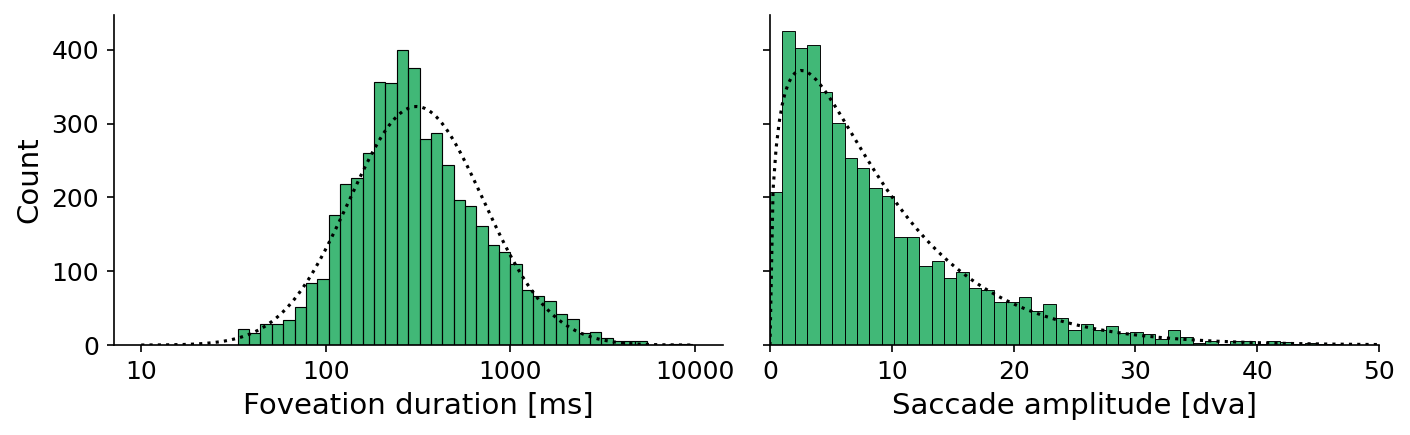

In [15]:
fig, axs = plt.subplots(1,2,dpi=150, figsize=(9.5,3), sharey=True)
sns.histplot(data=np.log10(gt_dur_ms), kde=False, ax=axs[0], bins=40, color=mcl[0])
axs[0].plot(durX, durPDF*FD_fac, color='k', ls=':')
axs[0].set_xticks([1,2,3,4])
axs[0].set_xticklabels([10,100,1000,10000])
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Count', size=14)
bins = np.linspace(0, 50, 50)
sns.histplot(data=gt_amp_dva, kde=False, ax=axs[1], bins=bins, color=mcl[0])
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].set_xlim([0, 50])
# axs[1].plot(ampX, ampPDF*SA_fac, color='k', ls=':', label='Fit')
axs[1].plot(ampX, ampPDF*SA_fac, color='k', ls=':', label='Fit')
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)
sns.despine()
plt.tight_layout(); plt.show()

### 4 c & d / 8 a
Compare the CDF summary statistics of the human data with the models. Show training in transparent and test in opaque.

Additionally, show the saccade turning angles for the human data and the models. This distribution was not used for fitting but is analyzed in the *Sequential scanpath evaluation*.

train


/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator


test


/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator


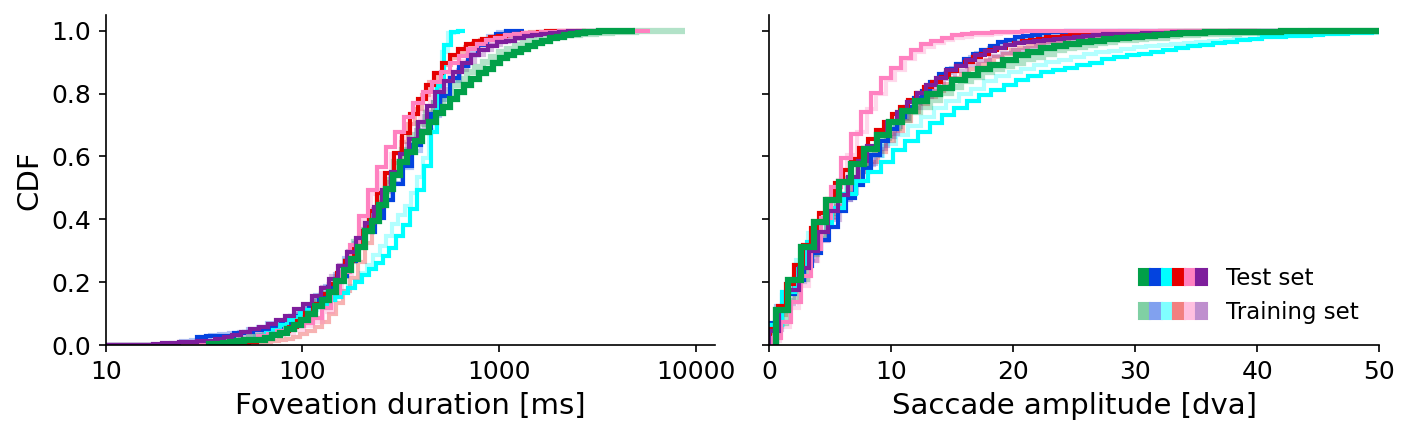

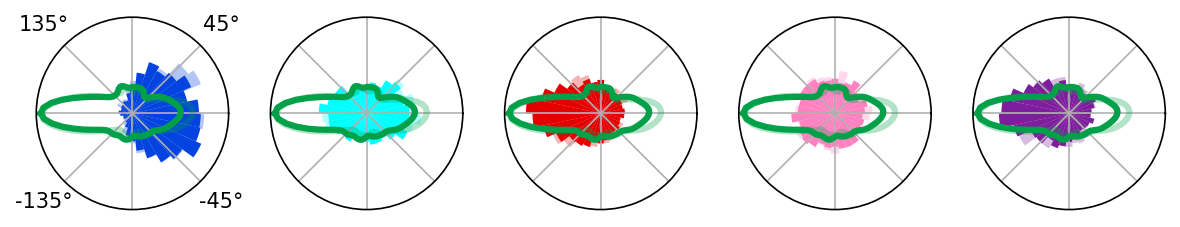

In [10]:
# prepare custom legend
handles1 = []; handles2 = []
for ind in range(len(mcl)):
    rgb = to_rgb(mcl[ind])
    handles1.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    handles2.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))

fig, axs = plt.subplots(1,2,dpi=150, figsize=(9.5,3), sharey=True) # fov_dur & sac_amp 
fig2, axs2 = plt.subplots(1,5,dpi=150, figsize=(8,2), subplot_kw={'projection': 'polar'})
ang_bins = 30
for modus in ["train", "test"]:
    c_idx = 0
    print(modus)

    if modus == "train":
        videoset = VidCom.trainset
        gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
        gt_ang_p = -VidCom.train_foveation_df["sac_angle_p"].dropna().values
        kwargs = {"alpha":0.3} #"ls":"dotted", "lw":3, 
    else:
        videoset = VidCom.testset
        gt_amp_dva = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.test_foveation_df["duration_ms"].dropna().values
        gt_ang_p = -VidCom.test_foveation_df["sac_angle_p"].dropna().values
        kwargs = {}#, "ls":"dotted", "alpha":0.5} "lw":2
    gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5]

    df_res_pxMolin_top0 = pd.read_csv(f'ScanDy_results/{run_ids[0]}/res_df_top0.csv.gz', compression='gzip')
    df_res_pxMolin_top0 = df_res_pxMolin_top0[df_res_pxMolin_top0['video'].isin(videoset)]
    px_llf_dur_ms = df_res_pxMolin_top0["duration_ms"].dropna().values
    px_llf_amp_dva = df_res_pxMolin_top0["sac_amp_dva"].dropna().values
    px_llf_ang_p = -df_res_pxMolin_top0["sac_angle_p"].dropna().values

    df_res_pxTased_top0 = pd.read_csv(f'ScanDy_results/{run_ids[1]}/res_df_top0.csv.gz', compression='gzip')
    df_res_pxTased_top0 = df_res_pxTased_top0[df_res_pxTased_top0['video'].isin(videoset)]
    px_hlf_dur_ms = df_res_pxTased_top0["duration_ms"].dropna().values 
    px_hlf_amp_dva = df_res_pxTased_top0["sac_amp_dva"].dropna().values 
    px_hlf_ang_p = -df_res_pxTased_top0["sac_angle_p"].dropna().values

    df_res_objMolin_top0 = pd.read_csv(f'ScanDy_results/{run_ids[2]}/res_df_top0.csv.gz', compression='gzip')
    df_res_objMolin_top0 = df_res_objMolin_top0[df_res_objMolin_top0['video'].isin(videoset)]
    obj_llf_dur_ms = df_res_objMolin_top0["duration_ms"].dropna().values
    obj_llf_amp_dva = df_res_objMolin_top0["sac_amp_dva"].dropna().values
    obj_llf_ang_p = -df_res_objMolin_top0["sac_angle_p"].dropna().values

    df_res_objNone_top0 = pd.read_csv(f'ScanDy_results/{run_ids[3]}/res_df_top0.csv.gz', compression='gzip')
    df_res_objNone_top0 = df_res_objNone_top0[df_res_objNone_top0['video'].isin(videoset)]
    obj_cb_dur_ms = df_res_objNone_top0["duration_ms"].dropna().values
    obj_cb_amp_dva = df_res_objNone_top0["sac_amp_dva"].dropna().values
    obj_cb_ang_p = -df_res_objNone_top0["sac_angle_p"].dropna().values

    df_res_mixMolin_top0 = pd.read_csv(f'ScanDy_results/{run_ids[4]}/res_df_top0.csv.gz', compression='gzip')
    df_res_mixMolin_top0 = df_res_mixMolin_top0[df_res_mixMolin_top0['video'].isin(videoset)]
    mix_llf_dur_ms = df_res_mixMolin_top0["duration_ms"].dropna().values
    mix_llf_amp_dva = df_res_mixMolin_top0["sac_amp_dva"].dropna().values
    mix_llf_ang_p = -df_res_mixMolin_top0["sac_angle_p"].dropna().values

    nbins = 60  # np.linspace(1, 4, 100)  # 60
    axs[0].hist(np.log10(px_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[0], color=mcl[1], lw=2, **kwargs)
    axs[0].hist(np.log10(px_hlf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[1], color=mcl[2], lw=2, **kwargs)
    axs[0].hist(np.log10(obj_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[2], color=mcl[3], lw=2, **kwargs)
    axs[0].hist(np.log10(obj_cb_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[3], color=mcl[4], lw=2, **kwargs)
    axs[0].hist(np.log10(mix_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[4], color=mcl[5], lw=2, **kwargs)
    axs[0].hist(np.log10(gt_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=gtname, color=mcl[0], lw=3, **kwargs)
    axs[0].set_xticks([1,2,3,4])
    axs[0].set_xlim([1, 4.1])
    axs[0].set_xticklabels([10,100,1000,10000], size=14)
    axs[0].tick_params(labelsize=12)
    axs[0].set_xlabel('Foveation duration [ms]', size=14)
    axs[0].set_ylabel('CDF', size=14)

    nbins = 60  # np.linspace(0, 50, 100)  # 60
    axs[1].hist(px_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[0], color=mcl[1], lw=2, **kwargs)
    axs[1].hist(px_hlf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[1], color=mcl[2], lw=2, **kwargs)
    axs[1].hist(obj_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[2], color=mcl[3], lw=2, **kwargs)
    axs[1].hist(obj_cb_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[3], color=mcl[4], lw=2, **kwargs)
    axs[1].hist(mix_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[4], color=mcl[5], lw=2, **kwargs)
    axs[1].hist(gt_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=gtname, color=mcl[0], lw=3, **kwargs)
    axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
    axs[1].tick_params(labelsize=12)
    axs[1].set_xlim([0, 50])
    #axs[1].legend(loc='lower right')
    uf.fix_hist_step_vertical_line_at_end(axs[0])
    uf.fix_hist_step_vertical_line_at_end(axs[1])

    x_p, kde_p = uf.vonmises_kde(gt_ang_p/180*np.pi, 50)

    data = [px_llf_ang_p, px_hlf_ang_p, obj_llf_ang_p, obj_cb_ang_p, mix_llf_ang_p]

    for i, ax in enumerate(axs2.flatten()):
        ax.hist(data[i]/180*np.pi, ang_bins, density=True, color=mcl[(i%5)+1], **kwargs)
        ax.plot(x_p, kde_p, color=mcl[0], lw=3, **kwargs)
        ax.set_yticks([])
        if i%5 > 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(["", "45°", "", "135°", "", "-135°", "", "-45°"]) 

axs[1].legend(bbox_to_anchor=(1,0), loc='lower right', 
            frameon=False, handles=[tuple(handles1), tuple(handles2)], labels=["Test set", "Training set"],
            title="", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize=11)
sns.despine(fig); fig.tight_layout() #; plt.show()

fig2.tight_layout(); # plt.show() # sns.despine(fig2); 

# legend in separate dummy figure
# fig, ax = plt.subplots(1,1,dpi=150, figsize=(4,3))
# ax.plot([0,1], [0,0], lw=3, label=gtname, color=mcl[0]); ax.plot([0,1], [0,0], lw=2, label=f"{names[0]} model", color=mcl[1]); ax.plot([0,1], [0,0], lw=2, label=f"{names[1]} model", color=mcl[2]); ax.plot([0,1], [0,0], lw=2, label=f"{names[2]} model", color=mcl[3]); ax.plot([0,1], [9,9], lw=2, label=f"{names[3]} model", color=mcl[4]); ax.plot([0,1], [9,9], lw=2, label=f"{names[4]} model", color=mcl[5])
# plt.legend(); plt.show()

## Fig 8 b & c
For the *Sequential scanpath evaluation* we also analyze the foveation duration depending on the saccade angle and the object-based return times. The results are shown in the following figures.

train, S.ll, Nsac=2799, cutoff n 1 % 0.04
train, S.hl, Nsac=2840, cutoff n 0 % 0.0
train, O.ll, Nsac=2986, cutoff n 0 % 0.0
train, O.cb, Nsac=2804, cutoff n 0 % 0.0
train, M.ll, Nsac=2690, cutoff n 0 % 0.0
test, S.ll, Nsac=3619, cutoff n 0 % 0.0
test, S.hl, Nsac=3528, cutoff n 0 % 0.0
test, O.ll, Nsac=4133, cutoff n 0 % 0.0
test, O.cb, Nsac=4090, cutoff n 0 % 0.0
test, M.ll, Nsac=3597, cutoff n 0 % 0.0


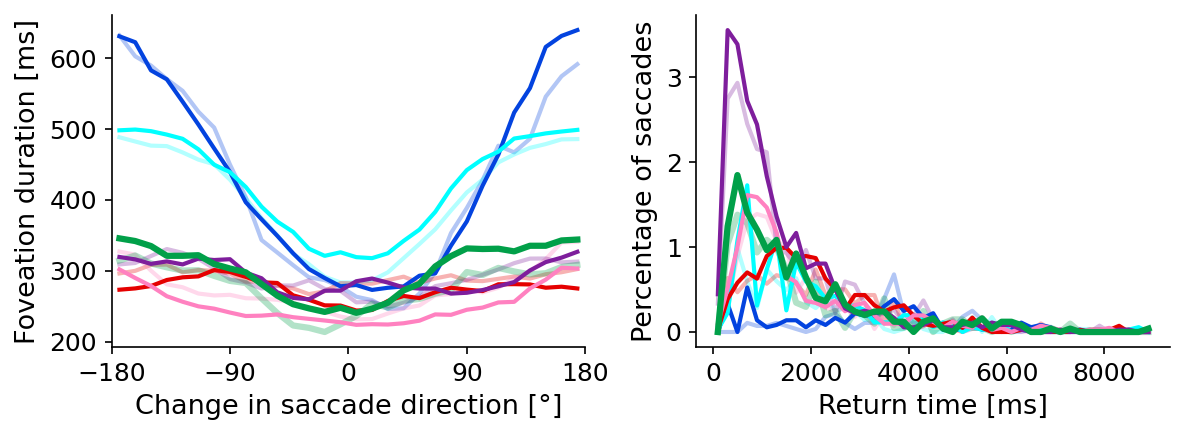

In [16]:
fig3, axs3 = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=False) # return times & fov_dur(ang)

ang_bins = 30
sma_ws = 5 
cutoff_t = 9000
ret_bins = np.linspace(0, cutoff_t, 46)

for modus in ["train", "test"]:
    if modus == "train":
        videoset = VidCom.trainset
        gt_df = VidCom.train_foveation_df
        kwargs = {"alpha":0.3} #"ls":"dotted", "lw":3, 
    else:
        videoset = VidCom.testset
        kwargs = {}#, "ls":"dotted", "alpha":0.5} "lw":2
        gt_df = VidCom.test_foveation_df
    
    rt_data = [gt_df["ret_times"].dropna().values]
    for r_i, runid in enumerate(run_ids):
        df = pd.read_csv(f'ScanDy_results/{runid}/res_df_top0.csv.gz', compression='gzip')
        df = df[df["video"].isin(videoset)]
        x_vals, all = uf.fovdur_vs_sacang(df, ang_bins, sma_ws)
        axs3[0].plot(x_vals, all, color=mcl[r_i+1], lw=2, **kwargs)
        counts, bins = np.histogram(df["ret_times"].dropna().values, ret_bins)
        Nsac = len(df["sac_amp_dva"].dropna())
        axs3[1].plot((bins[1:] + bins[:-1])/2, counts/Nsac, color=mcl[r_i+1], lw=2, **kwargs)    
        print(f"{modus}, {names[r_i]}, Nsac={Nsac}, cutoff n {np.sum(df.ret_times.dropna().values > cutoff_t)} % {round(np.sum(df.ret_times.dropna().values > cutoff_t)/Nsac * 100, 2)}")   
        # axs3[1].hist(bins[:-1], bins, weights=counts/Nsac, histtype='step', color=mcl[r_i+1], lw=2, **kwargs)
            
    x_vals, all = uf.fovdur_vs_sacang(gt_df, ang_bins, sma_ws)
    axs3[0].plot(x_vals, all, color=mcl[0], lw=3, **kwargs)
    counts, bins = np.histogram(gt_df["ret_times"].dropna().values, ret_bins)
    Nsac = len(gt_df["sac_amp_dva"].dropna())
    axs3[1].plot((bins[1:] + bins[:-1])/2, counts/Nsac, color=mcl[0], lw=3, **kwargs)        

axs3[1].set_xlabel('Return time [ms]', size=13)
axs3[1].set_ylabel('Percentage of saccades', size=13) # Density
axs3[1].set_yticks([0, 0.01, 0.02, 0.03])
axs3[1].set_yticklabels([0, 1, 2, 3])
axs3[1].tick_params(labelsize=12)


axs3[0].set_xlabel('Change in saccade direction [°]', size=13)
axs3[0].set_xlim(-180, 180)
axs3[0].set_yticks([200, 300, 400, 500, 600])
axs3[0].set_xticks([-180, -90, 0, 90, 180])
axs3[0].set_ylabel('Foveation duration [ms]', size=13)
axs3[0].tick_params(labelsize=12)

sns.despine(fig3); fig3.tight_layout(); plt.show()


## Fig 5

As suggested by the reviewers, we include all foveation categories over time (models were previously in Supplement).

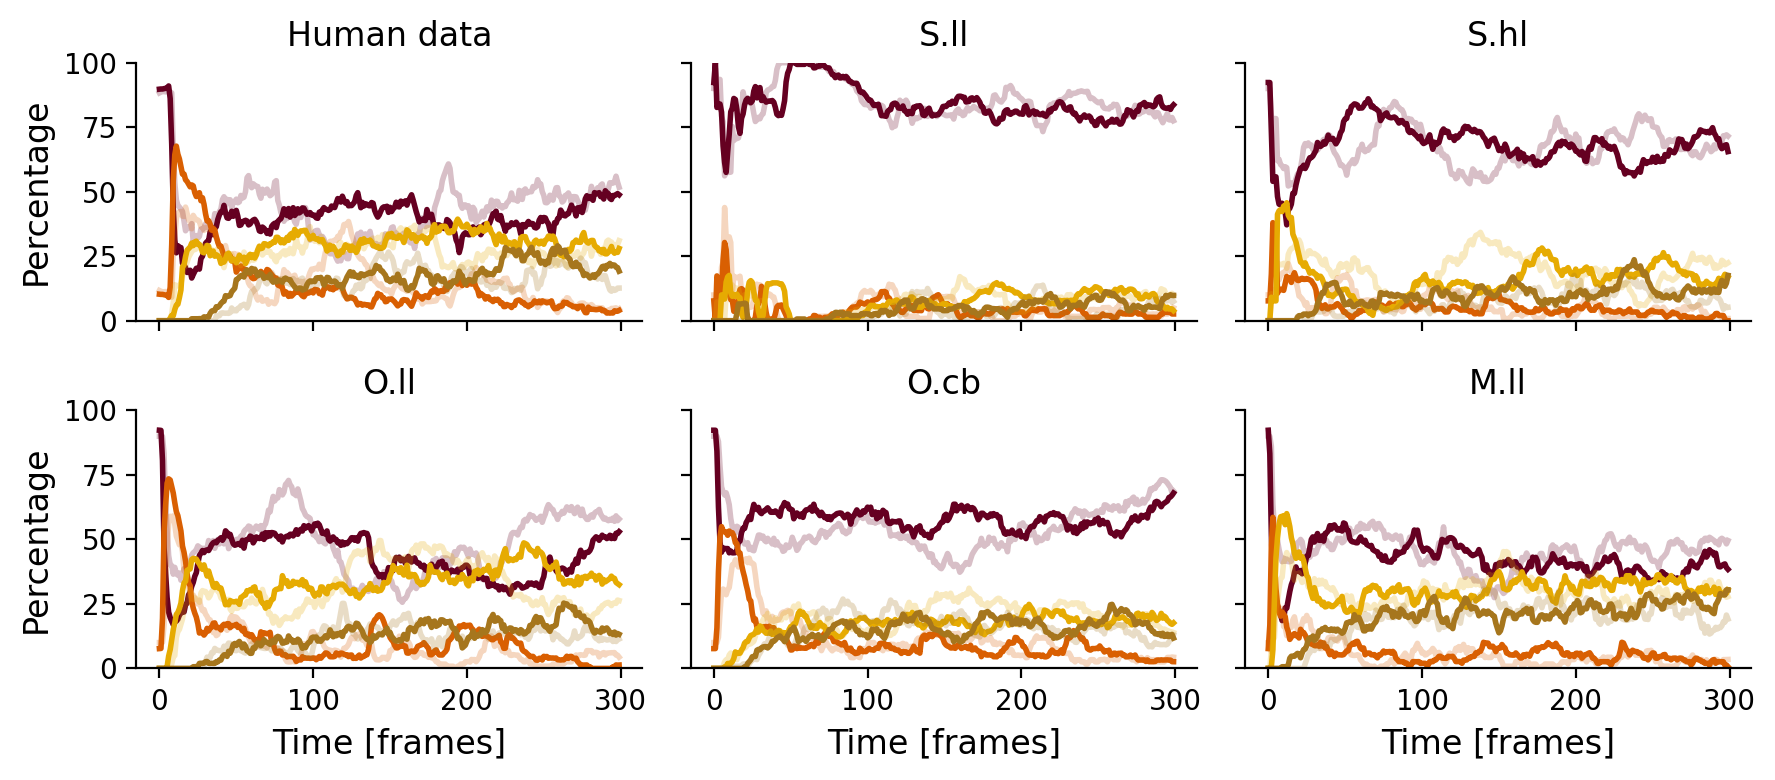

In [17]:
def get_BDIR_per_frames(df):    
    BDIR_per_frames = np.zeros((4,300))
    bdir_to_row = {'B': 0, 'D': 1, 'I': 2, 'R': 3}
    for index, row in df.iterrows():
        BDIR_per_frames[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1
    BDIR_ratios_per_frames = 100 * BDIR_per_frames / np.sum(BDIR_per_frames, axis=0)
    return BDIR_ratios_per_frames



fig, axs = plt.subplots(2,3, dpi=200, figsize=(9,4), sharex=True, sharey=True)

for ax_i, ax in enumerate(axs.flatten()):
    if ax_i == 0:
        ax.set_ylabel('Percentage', fontsize=12)
        ax.set_title(gtname, fontsize=12)
        ratios_train = get_BDIR_per_frames(VidCom.train_foveation_df)
        ratios_test = get_BDIR_per_frames(VidCom.test_foveation_df)
    else:
        model_idx = ax_i - 1
        runid = run_ids[model_idx]
        df = pd.read_csv(f'ScanDy_results/{runid}/res_df_top0.csv.gz', compression='gzip')
        ratios_train = get_BDIR_per_frames(df[df.video.isin(VidCom.trainset)])
        ratios_test = get_BDIR_per_frames(df[df.video.isin(VidCom.testset)])
        ax.set_title(names[model_idx], fontsize=12)

    for i in range(4):
        ax.plot(ratios_train[i], color=dircl[i], lw=2, alpha=0.25)
        ax.plot(ratios_test[i], color=dircl[i], lw=2, label=dirnames[i])

    if ax_i == 3:
        ax.set_ylabel('Percentage', fontsize=12)
    if ax_i > 2:
        ax.set_xlabel('Time [frames]', fontsize=12)
    ax.set_ylim(0,100)
sns.despine(); plt.tight_layout(); plt.show()


We reduce this to the barplot of the mean ratios, which is calculated afterwards.
First, look into the train/test boxplots!

## Fig 6: BDIR fractions relative to the human data


In [22]:
print("Fraction of the stimulus time taken up by foveation events in the human data: ", VidCom.get_foveation_ratio())
for runid in run_ids:
    model = ObjectModel(VidCom, preload_res_df=pd.read_csv(f'ScanDy_results/{runid}/res_df_top0.csv.gz', compression='gzip'))
    print(f"Foveation ratio for {runid}: ", model.get_foveation_ratio())

Fraction of the stimulus time taken up by foveation events in the human data:  0.7839665164874551
Foveation ratio for loc_train_molin_64-32-50_2023-08-01-10H-46M-11S_22770898:  0.8956750598343475
Foveation ratio for loc_train_TASEDnet_64-32-50_2023-08-01-10H-46M-30S_22770899:  0.8793752806394604
Foveation ratio for obj_train_molin_64-32-50_2023-08-01-10H-44M-52S_22770892:  0.8845619597103206
Foveation ratio for obj_train_None_64-32-50_2023-08-01-10H-43M-40S_22770884:  0.8985517188494165
Foveation ratio for mix_train_molin_64-32-50_2023-08-01-10H-45M-24S_22770894:  0.8954259311091946


MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7fd8bf6809e0>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7fd8c3a4f290>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7fd8bf680e60>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7fd8bf680b90>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7fd8bf680c20>


loc_train_molin_64-32-50_2023-08-01-10H-46M-11S_22770898
loc_train_molin_64-32-50_2023-08-01-10H-46M-11S_22770898 mean params
ddm_thres = $0.384 \pm 0.022$     & 0.384
ddm_sig = $0.011 \pm 0.001$     & 0.011
att_dva = $12.61 \pm 0.34$     & 12.51
ior_decay = $257.4 \pm 18.7$     & 253.3
ior_dva = $6.9 \pm 0.18$     & 7.01
Balancing of fitness function
$d_{FD} = 0.079 \pm 0.006$   top0: 0.071
$d_{SA} = 0.082 \pm 0.005$   top0: 0.082
Train,  S.ll [0.84901341 0.05096878 0.06615722 0.03386059]
Test,  S.ll [0.84927405 0.03971765 0.07057522 0.04043308]
Test ratio to GT,  S.ll [2.10689215 0.27583446 0.24145771 0.2517192 ]
loc_train_TASEDnet_64-32-50_2023-08-01-10H-46M-30S_22770899
loc_train_TASEDnet_64-32-50_2023-08-01-10H-46M-30S_22770899 mean params
ddm_thres = $1.72 \pm 0.026$     & 1.715
ddm_sig = $0.092 \pm 0.001$     & 0.092
att_dva = $11.08 \pm 0.7$     & 10.71
ior_decay = $290.9 \pm 6.9$     & 296.0
ior_dva = $4.52 \pm 0.04$     & 4.51
Balancing of fitness function
$d_{FD} = 0.184 \pm

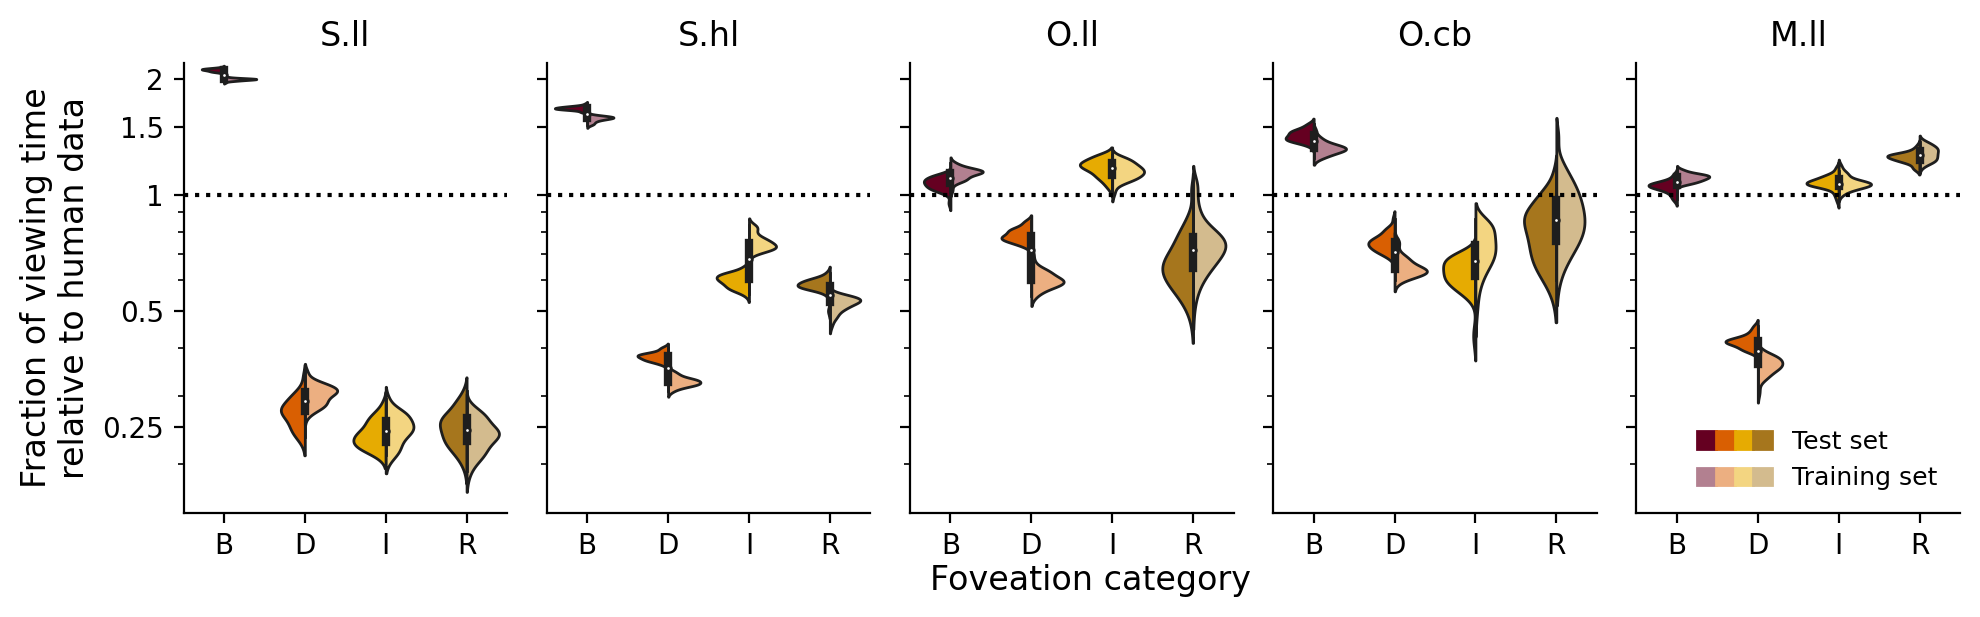

In [23]:
fig, axes = plt.subplots(1,5, sharex=True, sharey=True, figsize=(10,3), dpi=200)
report_par_decimals = [3,3,2,1,2]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())

mean_fovcats_train = []
mean_fovcats_test = []

evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    runid = run_ids[ax_i]
    print(runid)
    DILLNAME = f'{runid}.dill'
    if 'obj_' in runid:
        model = ObjectModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'loc_' in runid:
        model = LocationModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    elif 'mix_' in runid:
        model = MixedModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    evol = evol.loadEvolution(f'ScanDy_results/{runid}/{DILLNAME}')
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    # read in the computed simulation results
    train_fovcats = []
    test_fovcats = []
    for i in range(32):
        df_res = pd.read_csv(f'ScanDy_results/{runid}/res_df_top{i}.csv.gz', compression='gzip')
        model.result_df = df_res[df_res['video'].isin(VidCom.trainset)]
        train_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
        model.result_df = df_res[df_res['video'].isin(VidCom.testset)]
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    df_top32['train_fov_cat'] = train_fovcats
    df_top32['test_fov_cat'] = test_fovcats

    print(runid, "mean params")
    for i, par in enumerate(parameters):
        top_par = round(df_top32[par].iloc[0],report_par_decimals[i])
        print(f'{par} = ${round(df_top32[par].mean(),report_par_decimals[i])} \pm {round(df_top32[par].std(),report_par_decimals[i])}$     & {top_par}' )
    print("Balancing of fitness function")
    print("$d_{FD} =", f'{round(df_top32["f0"].mean(), 3)} \pm {round(df_top32["f0"].std(), 3)}$   top0: {round(df_top32["f0"].iloc[0], 3)}' )
    print("$d_{SA} =", f'{round(df_top32["f1"].mean(), 3)} \pm {round(df_top32["f1"].std(), 3)}$   top0: {round(df_top32["f1"].iloc[0], 3)}' )


    fovcats_train = [df_top32['train_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", names[ax_i], np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top32['train_fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(32)]
    
    fovcats_test = [df_top32['test_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    print("Test, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0))
    print("Test ratio to GT, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test))
    test_rel_fovcat = [df_top32['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(32)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='training set')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='test set')
    cdf = pd.concat([df_test_fovcats_rel_gt, df_train_fovcats_rel_gt])
    mdf = pd.melt(cdf, id_vars=['Data'], var_name=['Foveation category'])

    sns.violinplot(x="Foveation category", y="value", hue="Data", data=mdf, ax=ax, split=True, linewidth=1, palette={"test set": dircl[0], "training set": ".85"})    
    # df_fovcats_rel_gt.boxplot(ax=ax, grid=False)
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(dircl[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    ax.set_yscale('log')
    ax.set_ylim(0.15, 2.2)
    ax.set_yticks([0.25,0.5,1,1.5,2])
    ax.set_yticklabels([0.25,0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')

    if ax_i==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
        # ax.set_xlabel('Fov. category', size=14)
    else:
        ax.set_ylabel('')
    if ax_i==(len(axes.flat)-1):
        ax.legend(bbox_to_anchor=(1,0), loc='lower right', 
                  frameon=False, handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Test set", "Training set"],
                  title="", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize=9)
    else:
        ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_title(names[ax_i])
fig.text(0.55, 0.0, 'Foveation category', size=12, ha='center')    
plt.tight_layout()
sns.despine(); plt.show()

## Fig 5b Barplots
Use the means from the distributions plotted in Fig 6

Trainset


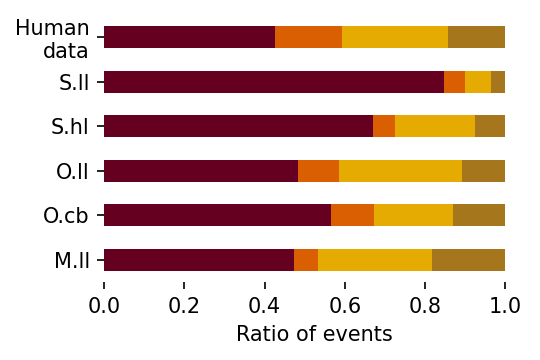

Testset


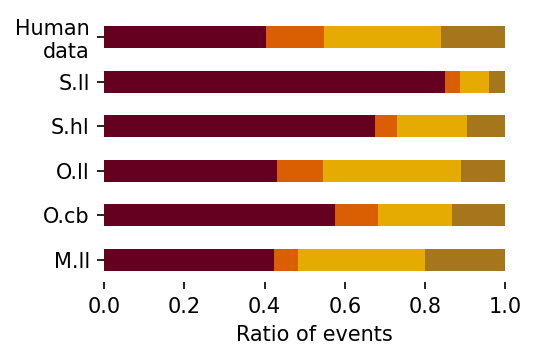

In [25]:
mean_fovcats_train_r = mean_fovcats_train[::-1]
mean_fovcats_test_r = mean_fovcats_test[::-1]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())

df_fovcats_train = pd.DataFrame(index=names[::-1] + ['Human\ndata'], 
                        data= mean_fovcats_train_r + [subjects_fovcat_train/sum(subjects_fovcat_train)])
df_fovcats_test = pd.DataFrame(index=names[::-1] + ['Human\ndata'], 
                        data= mean_fovcats_test_r + [subjects_fovcat_test/sum(subjects_fovcat_test)])

# fig, ax = plt.subplots(figsize=(3.5,2.5),dpi=150)
fig, ax = plt.subplots(figsize=(3.7,2.5),dpi=150)
df_fovcats_train.plot.barh(stacked=True, ax=ax,rot=0, legend=False, color=dircl)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Trainset')
print("Trainset")
plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(3.7,2.5),dpi=150)
df_fovcats_test.plot.barh(stacked=True, ax=ax,rot=0, legend=False, color=dircl)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Testset')
print("Testset")
plt.tight_layout(); plt.show()

## Fig. 7
Total dwell times on each individual object of the human data compared to the average of the parameter configurations of the models. (If only the best parameter is used for each model, the results are similar.)

_____________
loc_train_molin_64-32-50_2023-08-01-10H-46M-11S_22770898
train: slope: 0.05769475580620951, intercept: 445.81512114475174, r_value: 0.17591775316700634, p_value: 0.3899958652744595, std_err: 0.06590142443303917, r2 : 0.030947055879327768
test: slope: 0.29578626158347654, intercept: -10.423274364117844, r_value: 0.8555015174207564, p_value: 7.839701178034507e-12, std_err: 0.029837900678708774, r2 : 0.7318828463092169
\textit{S.ll} model: $m = 0.3, y_0 = -10, r = 0.86$, and $p<10^$ 7.839701178034507e-12
_____________
loc_train_TASEDnet_64-32-50_2023-08-01-10H-46M-30S_22770899
train: slope: 0.529553361539322, intercept: 205.3667362879503, r_value: 0.7044766915630922, p_value: 5.888349897973544e-05, std_err: 0.10890025162734185, r2 : 0.4962874089556802
test: slope: 0.645378324119866, intercept: -52.06547585636349, r_value: 0.931306182774311, p_value: 2.2897439165327898e-17, std_err: 0.04206830645201502, r2 : 0.8673312060736583
\textit{S.hl} model: $m = 0.65, y_0 = -52, r = 0.

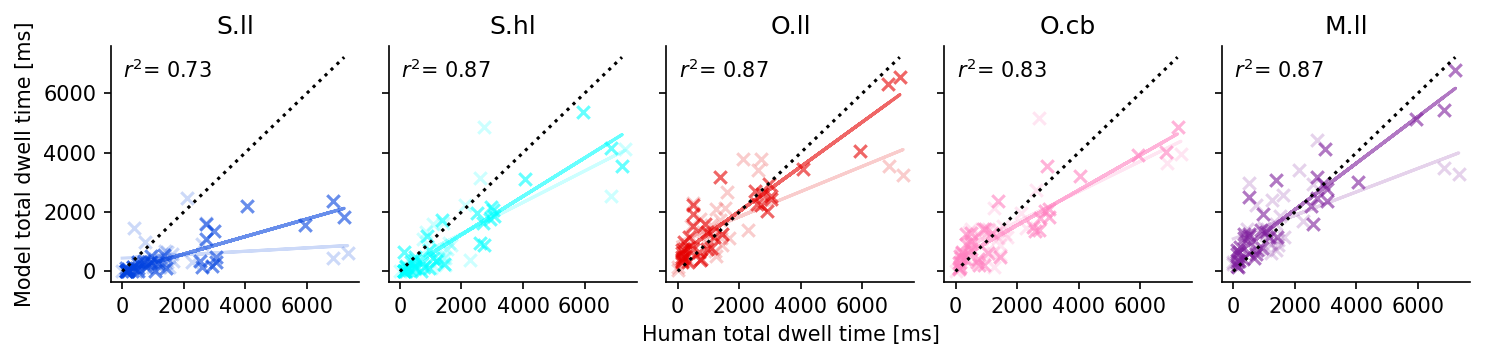

In [26]:
gtm = ObjectModel(VidCom)  # it doesnt matter what we choose here...
gtm.result_df = VidCom.gt_foveation_df
df_gt_obj = gtm.evaluate_all_obj()

fig, axs = plt.subplots(1,5, dpi=150, figsize=(10,2.5), sharey=True, sharex=True)

gtm = ObjectModel(VidCom)  # it doesnt matter what we choose here...
gtm.result_df = VidCom.gt_foveation_df
df_gt_obj = gtm.evaluate_all_obj()
for r_i, runid in enumerate(run_ids):
    print(f"_____________\n{runid}")
    m = ObjectModel(VidCom)
    merged_df = df_gt_obj.copy()
    for p_i in range(32): # use [0] for only the best parameter set
        m.result_df = pd.read_csv(f'ScanDy_results/{runid}/res_df_top{p_i}.csv.gz', compression='gzip')
        df_obj = m.evaluate_all_obj()
        temp = pd.DataFrame()
        temp["video"] = df_obj["video"]
        temp["object"] = df_obj["object"]
        temp[f"tot_t_{p_i}"] = df_obj["tot_t"]
        merged_df = merged_df.merge(temp, how="outer", on=['video', 'object'])
    merged_df = merged_df.fillna(0)
    merged_df["tot_t_SIM"] = merged_df[[f"tot_t_{i}" for i in range(32)]].mean(axis=1)
    merged_df["tot_t_GT"] = merged_df["tot_t"]

    for modus in ['train', 'test']:
        if modus == 'train':
            vidset = VidCom.trainset
            ma = 0.2
        else:
            vidset = VidCom.testset
            ma = 0.6
        set_df = merged_df[merged_df['video'].isin(vidset)]
        axs[r_i].scatter(set_df['tot_t_GT'], set_df['tot_t_SIM'], marker='x', c=mcl[r_i+1], alpha=ma)
        slope, intercept, r_value, p_value, std_err = stats.linregress(set_df['tot_t_GT'], set_df['tot_t_SIM'])
        print(f"{modus}: slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}, r2 : {r_value**2}")
        if modus == 'test':
            print("\\textit{"+names[r_i]+"} model: " + f"$m = {np.round(slope, 2)}, y_0 = {int(np.round(intercept))}, r = {np.round(r_value, 2)}$, and $p<10^$ {p_value}")
        axs[r_i].plot(set_df['tot_t_GT'], intercept + slope*set_df['tot_t_GT'], c=mcl[r_i+1], alpha=ma, label=f"r={np.round(r_value, 2)}, p={np.round(p_value, 4)}")
        if modus == 'test':  # f"y = {int(np.round(intercept))}+{np.round(slope, 2)}x\n" + 
            axs[r_i].text(0.05, 0.95, r"$r^2$"+f"= {np.round(r_value**2, 2)}", transform=axs[r_i].transAxes, fontsize=10, verticalalignment='top')
            axs[r_i].plot([0, set_df['tot_t_GT'].max()], [0, set_df['tot_t_GT'].max()], ls=":", color="k")
    axs[r_i].set_title(names[r_i])
    if r_i == 0:
        axs[r_i].set_ylabel("Model total dwell time [ms]") # \n(mean for objects across runs)
    if r_i==2:
        axs[r_i].set_xlabel("Human total dwell time [ms]") # (mean for each object across subjects)
    axs[r_i].set_xticks([0, 2000, 4000, 6000])

sns.despine(); plt.tight_layout(); plt.show()


Figures shown in the *Supplemental information* are created in the notebook `supplementary_information.ipynb`.